In [1]:
import numpy as np 
%matplotlib inline 
import matplotlib.pyplot as plt 
import os 
from keras import layers 
from keras.models import Model
from keras.models import load_model
from keras import callbacks 
import cv2 
import string
from random import shuffle

In [2]:
n=len(os.listdir("/Users/DELL/Downloads/archive"))
print("Size of dataset : ", n)

Size of dataset :  113062


In [3]:
imgshape=(40,150,1)
character= string.ascii_lowercase + string.ascii_uppercase + "0123456789" 
nchar = len(character) 
print("Image Dimensions : ", imgshape)
print("Number of possible characters : ", nchar)

Image Dimensions :  (40, 150, 1)
Number of possible characters :  62


In [4]:
def preprocess():
  X = np.zeros((n,40,150,1))
  y = np.zeros((5,n,nchar))
  for i, pic in enumerate(os.listdir("/Users/DELL/Downloads/archive")):
    img = cv2.imread(os.path.join("/Users/DELL/Downloads/archive", pic), cv2.IMREAD_GRAYSCALE) 
    pic_target = pic[:-4]
    if len(pic_target) < 6: 
      img = img / 255.0 
      img = np.reshape(img, (40, 150, 1))
      target=np.zeros((5,nchar))
      for j, k in enumerate(pic_target):
         index = character.find(k) 
         target[j, index] = 1
      X[i] = img 
      y[:,i] = target
  return X,y

In [5]:
def createmodel():
    img = layers.Input(shape=imgshape) 
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2) 
    conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(128, activation='relu')(flat)
        res = layers.Dense(nchar, activation='sigmoid')(dens1)
        outs.append(res)
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [6]:
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None: 
        img = img / 255.0 
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) 
    result = np.reshape(res, (5,62)) 
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) 
    capt = '' 
    for k in k_ind:
        capt += character[k] 
    return capt 

In [7]:
model=createmodel();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 150, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 150, 32)          320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 20, 75, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 20, 75, 64)           18496     ['max_pooling2d[0][0]']   

In [8]:
X_i,y_i=preprocess()
index_list = [i for i in range(n)]
shuffle(index_list)
X = X_i[index_list,:,:,:]
y = y_i[:,index_list,:]
X_train, y_train = X[:(8*n)//10], y[:, :(8*n)//10]
X_cv, y_cv = X[(8*n)//10:(9*n)//10], y[:, (8*n)//10:(9*n)//10]
X_test, y_test = X[(9*n)//10:], y[:, (9*n)//10:]

In [9]:
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=30, epochs=15, validation_split=0.3)

Epoch 1/15
2111/2111 [==============================] - 461s 217ms/step - loss: 16.2315 - dense_1_loss: 2.9583 - dense_3_loss: 3.3264 - dense_5_loss: 3.4167 - dense_7_loss: 3.4427 - dense_9_loss: 3.0874 - dense_1_accuracy: 0.2271 - dense_3_accuracy: 0.1602 - dense_5_accuracy: 0.1456 - dense_7_accuracy: 0.1397 - dense_9_accuracy: 0.2033 - val_loss: 11.3023 - val_dense_1_loss: 1.7715 - val_dense_3_loss: 2.4389 - val_dense_5_loss: 2.5724 - val_dense_7_loss: 2.5909 - val_dense_9_loss: 1.9287 - val_dense_1_accuracy: 0.4712 - val_dense_3_accuracy: 0.3498 - val_dense_5_accuracy: 0.3245 - val_dense_7_accuracy: 0.3099 - val_dense_9_accuracy: 0.4431
Epoch 2/15
2111/2111 [==============================] - 492s 233ms/step - loss: 8.7891 - dense_1_loss: 1.2685 - dense_3_loss: 1.9414 - dense_5_loss: 2.1207 - dense_7_loss: 2.0711 - dense_9_loss: 1.3874 - dense_1_accuracy: 0.6065 - dense_3_accuracy: 0.4595 - dense_5_accuracy: 0.4268 - dense_7_accuracy: 0.4294 - dense_9_accuracy: 0.5740 - val_loss: 7.9

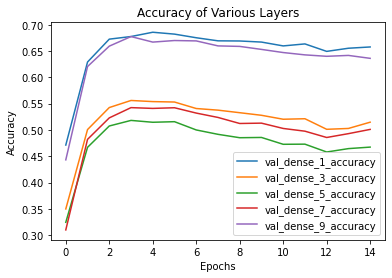

In [10]:
for label in ["val_dense_1_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_3_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_5_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_7_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_9_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Various Layers")
plt.show()

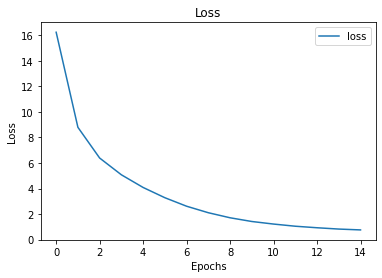

In [11]:
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

In [25]:
pred_train = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set = " + str(pred_train[0]))

2827/2827 [==============================] - 103s 36ms/step - loss: 5.5518 - dense_1_loss: 0.8474 - dense_3_loss: 1.2192 - dense_5_loss: 1.3409 - dense_7_loss: 1.2386 - dense_9_loss: 0.9057 - dense_1_accuracy: 0.8762 - dense_3_accuracy: 0.8208 - dense_5_accuracy: 0.7985 - dense_7_accuracy: 0.8091 - dense_9_accuracy: 0.8648
Loss on training set = 5.551809787750244


In [27]:
pred_cv = model.evaluate(X_cv, [y_cv[0], y_cv[1], y_cv[2], y_cv[3], y_cv[4]])
print ("Loss on cross validation set = " + str(pred_cv[0]))

354/354 [==============================] - 12s 34ms/step - loss: 16.6174 - dense_1_loss: 2.6293 - dense_3_loss: 3.5966 - dense_5_loss: 3.9806 - dense_7_loss: 3.6919 - dense_9_loss: 2.7190 - dense_1_accuracy: 0.6577 - dense_3_accuracy: 0.5293 - dense_5_accuracy: 0.4718 - dense_7_accuracy: 0.5020 - dense_9_accuracy: 0.6340
Loss on cross validation set = 16.61740493774414


In [28]:
pred_test = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print ("Loss on testing set = " + str(pred_test[0]))

354/354 [==============================] - 12s 34ms/step - loss: 16.4243 - dense_1_loss: 2.5932 - dense_3_loss: 3.5938 - dense_5_loss: 3.9532 - dense_7_loss: 3.6766 - dense_9_loss: 2.6075 - dense_1_accuracy: 0.6653 - dense_3_accuracy: 0.5217 - dense_5_accuracy: 0.4711 - dense_7_accuracy: 0.4951 - dense_9_accuracy: 0.6440
Loss on testing set = 16.424335479736328


1/1 [==============================] - 0s 39ms/step
Predicted Captcha = vUVYU


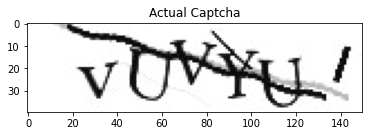

In [29]:
img=cv2.imread('/Users/DELL/Downloads/archive/vUVYU.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/vUVYU.jpg'))

1/1 [==============================] - 0s 31ms/step
Predicted Captcha = cD9AI


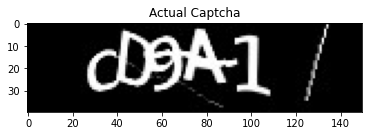

In [30]:
img=cv2.imread('/Users/DELL/Downloads/archive/cD9A1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/cD9A1.jpg'))

1/1 [==============================] - 0s 41ms/step
Predicted Captcha = 1a1SZ


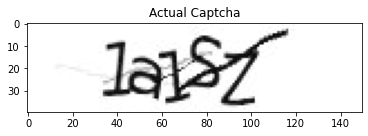

In [31]:
img=cv2.imread('/Users/DELL/Downloads/archive/1a1SZ.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/1a1SZ.jpg'))

1/1 [==============================] - 0s 30ms/step
Predicted Captcha = iF927


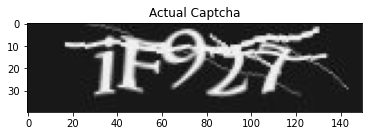

In [32]:
img=cv2.imread('/Users/DELL/Downloads/archive/iF927.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/iF927.jpg'))

1/1 [==============================] - 0s 25ms/step
Predicted Captcha = IhCtb


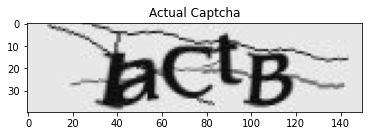

In [33]:
img=cv2.imread('/Users/DELL/Downloads/archive/1aCtB.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/1aCtB.jpg'))

1/1 [==============================] - 0s 32ms/step
Predicted Captcha = O1PAv


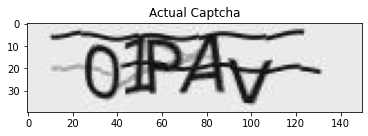

In [34]:
img=cv2.imread('/Users/DELL/Downloads/archive/O1PAv.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/O1PAv.jpg'))

1/1 [==============================] - 0s 22ms/step
Predicted Captcha = HFbku


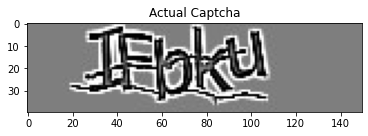

In [35]:
img=cv2.imread('/Users/DELL/Downloads/archive/IFbku.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/IFbku.jpg'))

1/1 [==============================] - 0s 25ms/step
Predicted Captcha = mBSpX


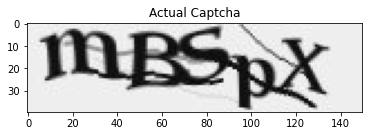

In [36]:
img=cv2.imread('/Users/DELL/Downloads/archive/mBSpX.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/mBSpX.jpg'))

1/1 [==============================] - 0s 34ms/step
Predicted Captcha = uN9Xb


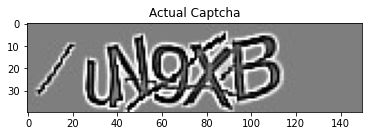

In [37]:
img=cv2.imread('/Users/DELL/Downloads/archive/uN9XB.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/uN9XB.jpg'))

1/1 [==============================] - 0s 22ms/step
Predicted Captcha = EVqqt


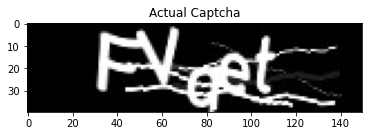

In [38]:
img=cv2.imread('/Users/DELL/Downloads/archive/FVqet.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Actual Captcha")
print("Predicted Captcha =",predict('/Users/DELL/Downloads/archive/FVqet.jpg'))